In [70]:
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib
from matplotlib import pyplot as plt

# Recognize

In [2]:
img = cv.imread("./test_images/3.jpg")
img.shape

(1200, 1200, 3)

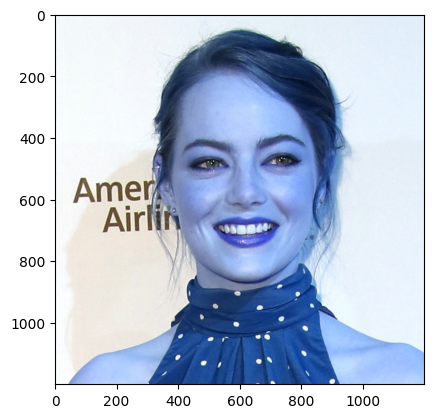

In [3]:
plt.imshow(img)
plt.show()

In [4]:
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray

array([[248, 247, 247, ..., 240, 238, 237],
       [248, 247, 247, ..., 240, 238, 237],
       [248, 247, 247, ..., 240, 239, 238],
       ...,
       [255, 254, 252, ..., 221, 221, 220],
       [255, 255, 254, ..., 221, 221, 220],
       [255, 255, 255, ..., 221, 221, 220]], dtype=uint8)

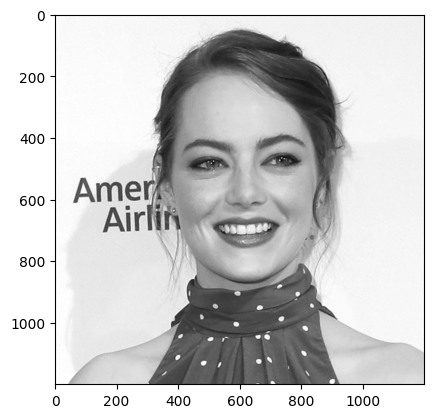

In [5]:
plt.imshow(gray, cmap="gray")
plt.show()

In [6]:
face_cascade = cv.CascadeClassifier("./haarcascades/haarcascade_frontalface_default.xml")
eyes_cascade = cv.CascadeClassifier("./haarcascades/haarcascade_eye.xml")

faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
faces

array([[324, 241, 612, 612]])

In [7]:
x,y,w,h = faces[0]
x,y,w,h

(324, 241, 612, 612)

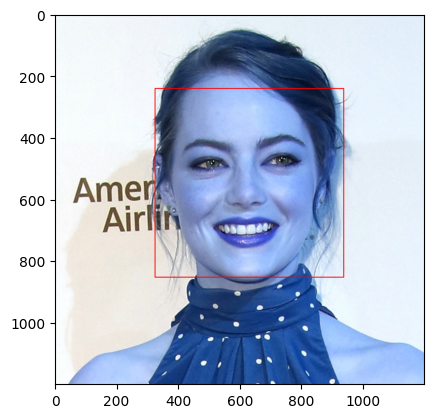

In [8]:
face_img = cv.rectangle(img, (x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)
plt.show()

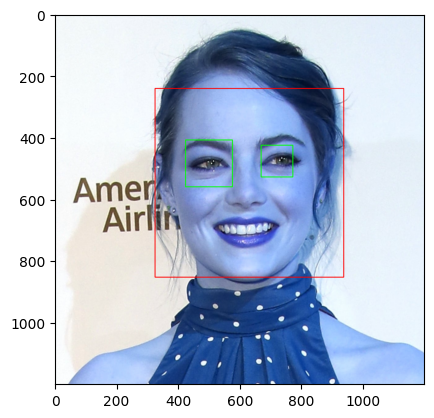

In [9]:
cv.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv.rectangle(img, (x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eyes_cascade.detectMultiScale(roi_gray, scaleFactor=1.3, minNeighbors=5)
    for(ex,ey,ew,eh) in eyes:
        cv.rectangle(roi_color, (ex,ey), (ex+ew,ey+eh), (0, 255, 0 ), 2)

        
plt.imshow(face_img, cmap="gray")
plt.show()

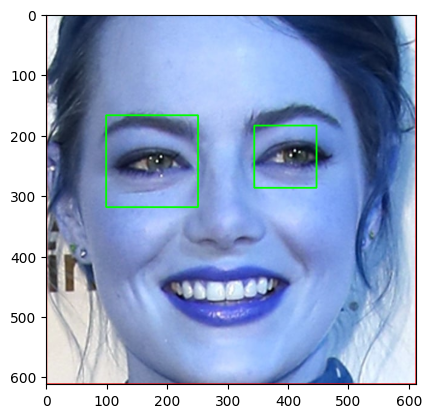

In [10]:
plt.imshow(roi_color, cmap="gray")
plt.show()

In [11]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv.imread(image_path)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
    for (x,y,w,h) in faces:
        face_img = cv.rectangle(img, (x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = face_img[y:y+h, x:x+w]
        eyes = eyes_cascade.detectMultiScale(roi_gray, scaleFactor=1.3, minNeighbors=5)
        if len(eyes) >= 2:
            return roi_color

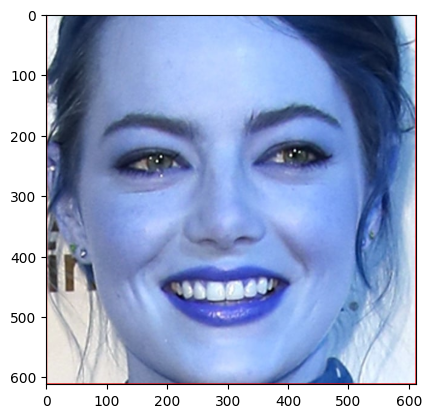

In [12]:
plt.imshow(get_cropped_image_if_2_eyes("./test_images/3.jpg"))
plt.show()

# Crop

In [13]:
data_path = "./dataset/"
crop_data_path = "./dataset/cropped/"

In [14]:
import os
img_dirs = []
for entry in os.scandir(data_path):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [15]:
img_dirs

['./dataset/ana_de_armas',
 './dataset/christian_bale',
 './dataset/cropped',
 './dataset/emma_stone',
 './dataset/henry_cavill',
 './dataset/jennifer_lawrence',
 './dataset/margot_robbie']

In [16]:
import shutil
if os.path.exists(crop_data_path):
    shutil.rmtree(crop_data_path)
os.mkdir(crop_data_path)

In [17]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    if img_dir.split('/')[-1]=="cropped":
        continue
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = crop_data_path + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder:  ./dataset/cropped/ana_de_armas
Generating cropped images in folder:  ./dataset/cropped/christian_bale
Generating cropped images in folder:  ./dataset/cropped/emma_stone
Generating cropped images in folder:  ./dataset/cropped/henry_cavill
Generating cropped images in folder:  ./dataset/cropped/jennifer_lawrence
Generating cropped images in folder:  ./dataset/cropped/margot_robbie


# Wavelet Transform

In [18]:
%pip install PyWavelets

Note: you may need to restart the kernel to use updated packages.


In [19]:
import pywt

In [20]:
cropped_img = np.array(roi_color)
cropped_img.shape

(555, 555, 3)

In [21]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv.cvtColor( imArray,cv.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

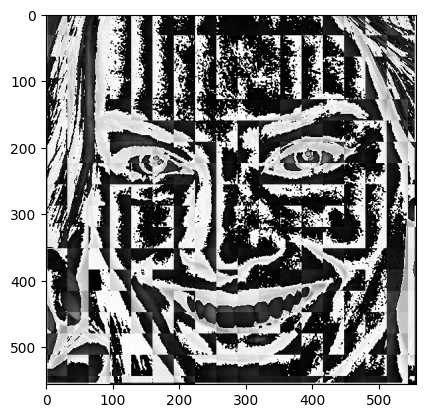

In [22]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

In [23]:
celebrity_file_names_dict

{'ana_de_armas': ['./dataset/cropped/ana_de_armas/ana_de_armas1.png',
  './dataset/cropped/ana_de_armas/ana_de_armas2.png',
  './dataset/cropped/ana_de_armas/ana_de_armas3.png',
  './dataset/cropped/ana_de_armas/ana_de_armas4.png',
  './dataset/cropped/ana_de_armas/ana_de_armas5.png',
  './dataset/cropped/ana_de_armas/ana_de_armas6.png',
  './dataset/cropped/ana_de_armas/ana_de_armas7.png',
  './dataset/cropped/ana_de_armas/ana_de_armas8.png',
  './dataset/cropped/ana_de_armas/ana_de_armas9.png',
  './dataset/cropped/ana_de_armas/ana_de_armas10.png',
  './dataset/cropped/ana_de_armas/ana_de_armas11.png',
  './dataset/cropped/ana_de_armas/ana_de_armas12.png',
  './dataset/cropped/ana_de_armas/ana_de_armas13.png',
  './dataset/cropped/ana_de_armas/ana_de_armas14.png',
  './dataset/cropped/ana_de_armas/ana_de_armas15.png',
  './dataset/cropped/ana_de_armas/ana_de_armas16.png',
  './dataset/cropped/ana_de_armas/ana_de_armas17.png',
  './dataset/cropped/ana_de_armas/ana_de_armas18.png',
  '

In [24]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'ana_de_armas': 0,
 'christian_bale': 1,
 'emma_stone': 2,
 'henry_cavill': 3,
 'jennifer_lawrence': 4,
 'margot_robbie': 5}

In [28]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv.imread(training_image)
        if img is None:
            continue
        scalled_raw_img = cv.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

In [29]:
len(X)

353

In [30]:
len(y)

353

In [36]:
y.uni

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,


In [33]:
X[0]

array([[194],
       [  2],
       [  5],
       ...,
       [  6],
       [  3],
       [ 16]], dtype=uint8)

In [34]:
len(X[0])

4096

In [35]:
32*32*3 + 32*32

4096

In [37]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(353, 4096)

In [38]:
X[0]

array([194.,   2.,   5., ...,   6.,   3.,  16.])

In [39]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'ana_de_armas': ['./dataset/cropped/ana_de_armas\\ana_de_armas1.png',
  './dataset/cropped/ana_de_armas\\ana_de_armas10.png',
  './dataset/cropped/ana_de_armas\\ana_de_armas11.png',
  './dataset/cropped/ana_de_armas\\ana_de_armas12.png',
  './dataset/cropped/ana_de_armas\\ana_de_armas13.png',
  './dataset/cropped/ana_de_armas\\ana_de_armas14.png',
  './dataset/cropped/ana_de_armas\\ana_de_armas15.png',
  './dataset/cropped/ana_de_armas\\ana_de_armas16.png',
  './dataset/cropped/ana_de_armas\\ana_de_armas17.png',
  './dataset/cropped/ana_de_armas\\ana_de_armas18.png',
  './dataset/cropped/ana_de_armas\\ana_de_armas19.png',
  './dataset/cropped/ana_de_armas\\ana_de_armas2.png',
  './dataset/cropped/ana_de_armas\\ana_de_armas20.png',
  './dataset/cropped/ana_de_armas\\ana_de_armas21.png',
  './dataset/cropped/ana_de_armas\\ana_de_armas22.png',
  './dataset/cropped/ana_de_armas\\ana_de_armas23.png',
  './dataset/cropped/ana_de_armas\\ana_de_armas24.png',
  './dataset/cropped/ana_de_armas\

# Train

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel = "linear"))
])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.6629213483146067

In [65]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.73      0.57      0.64        14
           1       0.80      0.67      0.73        12
           2       0.67      0.67      0.67        18
           3       0.90      0.82      0.86        11
           4       0.75      0.63      0.69        19
           5       0.42      0.67      0.51        15

    accuracy                           0.66        89
   macro avg       0.71      0.67      0.68        89
weighted avg       0.70      0.66      0.67        89



In [78]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [84]:
model_params = {
    "svm":{
        "model":SVC(gamma="auto", probability=True),
        "params":{
            "svc__C": [1,10,100],
            "svc__kernel": ["rbf", "linear"]
        } 
    },
    "random_forest":{
        "model":RandomForestClassifier(),
        "params":{
            "randomforestclassifier__n_estimators":[1,5,10,50,100]
        }
    },
    "logistic_regression":{
        "model": LogisticRegression(),
        "params":{
            "logisticregression__solver":['lbfgs','liblinear'],
            "logisticregression__C":[1,5,10]
        }
    },
    "gaussian_naive_bayes":{
        "model": GaussianNB(),
        "params": {}
    },

}

In [85]:
scores = []
best_estimators = {}

for model_name, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[model_name] = clf.best_estimator_

C:\Users\emirk\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\emirk\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

In [86]:
df = pd.DataFrame(scores)
df

,model,best_score,best_params
0,svm,0.696952,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.541800,{'randomforestclassifier__n_estimators': 100}
2,logistic_regression,0.742453,"{'logisticregression__C': 1, 'logisticregressi..."
3,gaussian_naive_bayes,0.496372,{}


In [91]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier', RandomForestClassifier())]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))]),
 'gaussian_naive_bayes': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('gaussiannb', GaussianNB())])}

In [87]:
best_estimators['svm'].score(X_test,y_test)

0.6629213483146067

In [90]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.7078651685393258

In [92]:
best_clf = best_estimators['logistic_regression']

In [93]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[11,  0,  0,  0,  0,  3],
       [ 1,  9,  1,  1,  0,  0],
       [ 0,  1, 16,  0,  1,  0],
       [ 0,  1,  0, 10,  0,  0],
       [ 0,  1,  2,  0, 12,  4],
       [ 1,  2,  2,  1,  4,  5]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

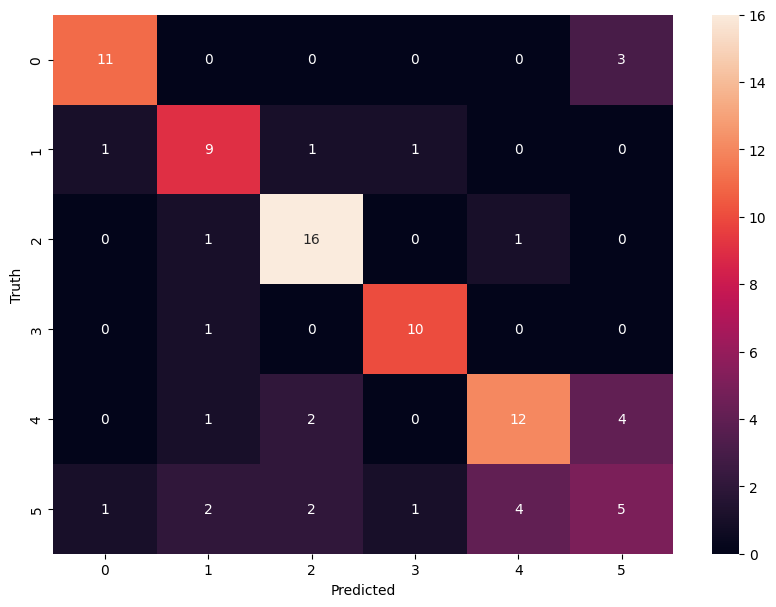

In [94]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [95]:
class_dict

{'ana_de_armas': 0,
 'christian_bale': 1,
 'emma_stone': 2,
 'henry_cavill': 3,
 'jennifer_lawrence': 4,
 'margot_robbie': 5}

In [96]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

In [97]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))